In [1]:
# Import necessary libraries
import torch # Deep learning framework
from torchvision import datasets, transforms  # Image manipulation library
import matplotlib.pyplot as plt # Plotting library
import torch.nn as nn # Neural network module from PyTorch
import torch.nn.functional as F # Functional interface for PyTorch operations
import torch.optim as optim # Optimization module from PyTorch
import torch.optim.lr_scheduler as lr_scheduler # Learning rate scheduling module from PyTorch

# Task 1 - Read datasets and create dataloaders

To enhance the effectiveness of the model in recognizing new images, we employ data augmentation techniques on the training set. These techniques involve applying various transformations, such as - 

1. RandomResizedCrop: Randomly crop and resize images with padding.

2. RandomRotation: Randomly rotate images up to 15 degrees.

3. RandomHorizontalFlip: With a 50% chance, the images are horizontally flipped.

4. ToTensor: Convert images to PyTorch tensors.

5. Normalize: Normalize images by subtracting the mean (0.5) and dividing by the standard deviation (0.5) for each color channel.


The validation set, on the other hand, undergoes only the conversion to tensor and normalization transformations to maintain the original images. Both the training and validation datasets are then loaded into DataLoader instances with a batch size of 64, enabling batching, shuffling, and parallel processing during both training and testing phases.

In [2]:
# Define the transformations to be applied to the training data for data augmentation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define the transformations to be applied to the test data for evaluation
transform_test = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training and test data using CIFAR10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

# Load the training and test data with specified transformations
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 66600984.15it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Now we displays 15 images from the CIFAR-10 training set with their corresponding labels. The train_loader DataLoader instance is used to obtain the images and their labels, and the classes variable stores the names of the classes in the CIFAR-10 dataset. We normalize the images first and then display them using matplotlib. By visualizing the images, the data preprocessing steps applied during the training are evident.

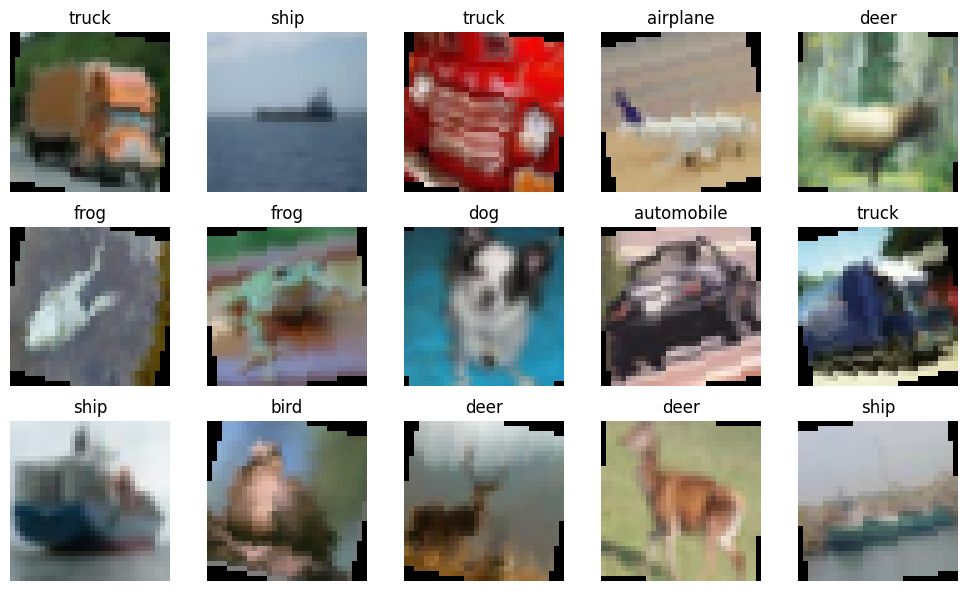

In [3]:
# Get a batch of 15 images from the training set
dataiter = iter(train_loader)
images, labels = dataiter.__next__()
images = images[:15]
labels = labels[:15]

# Define the class names for CIFAR-10 dataset
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the images and their labels
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    # Get the image and its label
    image = images[i].numpy().transpose((1, 2, 0))
    label = classes[labels[i].item()]
    # Plot the image and its label
    ax.imshow((image + 1) / 2) # unnormalize and show
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Task 2 - Create the Model

Model Architecture - The ResNet-based CNN model is composed of a backbone and a classifier.

Backbone:
The backbone is a sequence of 7 blocks, each of which consists of convolutional layers, batch normalization, and a PReLU activation function. The purpose of the backbone is to extract relevant features from the input image, by applying convolutional filters and nonlinear transformations. Specifically, each block uses adaptive convolutions, where the weights of the convolutional filters are learned from the input image by applying a fully connected layer to obtain channel-wise weights. These weights are then applied to the convolutional filters to produce the output of the block. Additionally, every other block in the backbone includes a max pooling layer, which reduces the spatial dimensions of the input and increases the number of channels.

Classifier:
The output of the 7th block of the backbone is then passed to the classifier, which consists of a global average pooling layer, a flatten layer, and a fully connected layer with 10 output neurons, corresponding to the 10 possible classes in the classification task. The purpose of the classifier is to take the feature representations learned by the backbone and produce a final classification decision. The global average pooling layer reduces the spatial dimensions of the feature map to 1x1, while preserving the channel information. The flatten layer then converts the feature map into a 1D vector, which is fed into the fully connected layer to produce the final class scores.

In [4]:
# Define a Block class, representing a building block for the Model
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, k=3):
        super(Block, self).__init__()
        # Average pooling layer to reduce the spatial dimensions to 1x1
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        # Fully connected layer to obtain channel-wise weights for adaptive convolutions
        self.fc = nn.Linear(in_channels, k)
        
        # Convolutional layers for the block
        self.convs = nn.ModuleList()
        for _ in range(k):
            conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
            # Initialize the weights of the convolutional layer using Kaiming normal distribution
            nn.init.kaiming_normal_(conv.weight, mode='fan_in', nonlinearity='relu')
            self.convs.append(conv)
            
        # Residual connection
        self.residual = nn.Sequential()
        if in_channels != out_channels:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_channels)
            )
            # Initialize the weights of the residual connection using Kaiming normal distribution
            nn.init.kaiming_normal_(self.residual[0].weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        b, c, _, _ = x.size()
        # Calculate the channel-wise weights using the fully connected layer and apply softmax function
        a = self.fc(self.avg_pool(x).view(b, c))
        a = F.softmax(a, dim=1).view(b, -1, 1, 1)

        # Perform the adaptive convolutions with the calculated weights
        out = 0
        for i, conv in enumerate(self.convs):
            out += a[:, i:i + 1] * conv(x)
        
        # Add the residual connection to the output
        res = self.residual(x)
        out += res
        return out

# Define the Model class
class Model(nn.Module):
    def __init__(self, num_blocks=7, num_channels=64): 
        super(Model, self).__init__()
        # Define the backbone of the model as a sequence of blocks and other layers
        backbone_layers = []
        in_channels = 3
        out_channels = num_channels
        for i in range(num_blocks):
            # Append Block, BatchNorm, and PReLU layers to the backbone
            backbone_layers.append(Block(in_channels, out_channels))
            backbone_layers.append(nn.BatchNorm2d(out_channels))
            backbone_layers.append(nn.PReLU())
            in_channels = out_channels
            # Append MaxPool2d layer to the backbone at specific block indices
            if i in [1, 3, 5]:
                out_channels *= 2
                backbone_layers.append(nn.MaxPool2d(2, 2))
        self.backbone = nn.Sequential(*backbone_layers)

        # Define the classifier as a sequence of layers
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Reduce the spatial dimensions to 1x1
            nn.Flatten(),                 # Flatten the tensor into a 1D vector
            nn.Linear(out_channels, 10)   # Fully connected layer to produce the final class scores
        )

    # Define the forward pass of the model
    def forward(self, x):
        x = self.backbone(x)          # Pass the input through the backbone network
        x = self.classifier(x)        # Pass the output of the backbone through the classification network
        return x

In [5]:
# Create an instance of the Model class
model = Model()

# Task 3 - Create the loss and optimizer

1. Loss Function:
A custom loss function called "LabelSmoothingCrossEntropyLoss" is defined to handle label smoothing in the training process.
The loss function calculates log probabilities of the input tensor using log_softmax and then calculates the cross-entropy loss with element-wise multiplication of weights and log probabilities, summing along the class dimension, and then taking the mean value.
The weight values for the target class and non-target classes are calculated based on the smoothing value and the number of classes.

2. Optimizer:
RMSprop optimizer is used to optimize the model parameters.
The optimizer has parameters such as learning rate, alpha, eps, weight_decay, and momentum.
The learning rate is set to 0.001, alpha to 0.99, eps to 1e-08, weight_decay to 0, and momentum to 0.9.

3. Scheduler:
A learning rate scheduler is defined with cosine annealing.
The scheduler reduces the learning rate by gradually decreasing it to eta_min (1e-6 in this case) over T_max (100 in this case) epochs.

In [6]:
# Define the custom loss function
class LabelSmoothingCrossEntropyLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingCrossEntropyLoss, self).__init__()
        # Initialize the label smoothing value
        self.smoothing = smoothing

    def forward(self, input, target):

        # Calculate the log probabilities of the input tensor using log_softmax
        log_prob = F.log_softmax(input, dim=-1)
        
        # Create a new tensor with the same size as the input tensor, filled with the smoothing value
        # divided by the number of classes minus 1 (this is the weight for non-target classes)
        weight = input.new_ones(input.size()) * self.smoothing / (input.size(-1) - 1.)
        
        # Replace the weight values corresponding to the target class indices with 1 - smoothing value
        # (this is the weight for the target class)
        weight.scatter_(-1, target.unsqueeze(-1), (1. - self.smoothing))
        
        # Calculate the cross-entropy loss by multiplying the weights and log probabilities element-wise,
        # summing along the class dimension, and then taking the mean value
        ce_loss = (-weight * log_prob).sum(dim=-1).mean()

        return ce_loss

# Create an instance of the custom loss function with 0.1 label smoothing
criterion = LabelSmoothingCrossEntropyLoss(smoothing=0.2)

# Define the optimizer with RMSprop and momentum
optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0.9, centered=False)

# Define the learning rate scheduler with cosine annealing
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-6)

In [7]:
# Set the device to use for training and validation (GPU if available, else CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Model(
  (backbone): Sequential(
    (0): Block(
      (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc): Linear(in_features=3, out_features=3, bias=True)
      (convs): ModuleList(
        (0-2): 3 x Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (residual): Sequential(
        (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Block(
      (avg_pool): AdaptiveAvgPool2d(output_size=(1, 1))
      (fc): Linear(in_features=64, out_features=3, bias=True)
      (convs): ModuleList(
        (0-2): 3 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (residual): Sequential()
    )
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): PReLU

# Task 4 - Write the training script to train the model

Training Function - 

The train_epoch function trains a given neural network model for one epoch using the above dataloader, criterion, optimizer, and device. During training, the function accumulates gradients for a specified number of mini-batches (num_accumulation_steps) before updating the model parameters, which helps to reduce memory usage and speed up training. The function calculates the loss and accuracy for the epoch and returns these values. Additionally, the function sets the model to training mode and moves the data to the specified device.

In [8]:
def train_epoch(model, dataloader, criterion, optimizer, device, num_accumulation_steps=4):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    num_correct = 0
    num_total = 0
    
    optimizer.zero_grad()  # Reset gradients outside the loop
  
    # Loop through the training data (images and labels)
    for i, (batch_images, batch_labels) in enumerate(dataloader):
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)  # Move images and labels to the device
        outputs = model(batch_images)  # Forward pass through the model
        batch_loss = criterion(outputs, batch_labels)  # Calculate the loss
        batch_loss /= num_accumulation_steps  # Divide the loss by the number of accumulation steps

        batch_loss.backward()  # Perform backpropagation to compute gradients

        # Update model parameters after accumulating gradients for 'num_accumulation_steps' mini-batches
        if (i + 1) % num_accumulation_steps == 0:
            optimizer.step()  # Update the model parameters
            optimizer.zero_grad()  # Reset the gradients

        running_loss += batch_loss.item()  # Accumulate the loss
        _, predicted = outputs.max(1)  # Get the predicted class labels
        num_total += batch_labels.size(0)  # Update the total number of samples
        num_correct += predicted.eq(batch_labels).sum().item()  # Count the number of correct predictions

    # Update the model parameters one last time if there are any remaining gradients
    if (i + 1) % num_accumulation_steps != 0:
        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = running_loss / len(dataloader) * num_accumulation_steps  # Calculate the average loss for the epoch
    epoch_acc = num_correct / num_total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_acc

Validation Function - 

The validation_epoch function evaluates a given neural network model for one epoch using a specified dataloader, criterion, and device. It sets the model to evaluation mode and loops through the test data to calculate the loss and accuracy of the model's predictions. For each batch of validation data, the function moves the batch images and labels to the specified device, performs a forward pass through the model using torch.no_grad(), calculates the loss using the specified criterion, and accumulates the loss. It also gets the predicted class labels and counts the number of correct predictions. At the end of the loop, it calculates the average loss and accuracy for the epoch and returns these values.

In [9]:
def validation_epoch(model, dataloader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    num_correct = 0
    num_total = 0
    num_batches = 0

    # Loop through the test data
    for i, (batch_images, batch_labels) in enumerate(dataloader):
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)  # Move data and target to the device

        # Forward pass through the model
        with torch.no_grad():
            output = model(batch_images)

        # Calculate the loss
        loss = criterion(output, batch_labels)
        running_loss += loss.item()  # Accumulate the loss

        # Get the predicted class labels
        _, predicted = torch.max(output, dim=1)

        # Count the number of correct predictions
        num_correct += predicted.eq(batch_labels).sum().item()

        num_total += batch_labels.size(0)  # Update the total number of samples
        num_batches += 1

    epoch_loss = running_loss / num_batches  # Calculate the average loss for the epoch
    epoch_acc = num_correct / num_total  # Calculate the accuracy for the epoch

    return epoch_loss, epoch_acc

Training the model - 

Here we train and validate the model for 40 epochs, stores the training and validation loss and accuracy history for each epoch, and prints the results at the end of each epoch.

We begin by defining the number of epochs = 40 to train for and initializing empty lists to store the training and validation loss and accuracy history.

Then we use loops to move through each epoch, train the model for one epoch using the train_epoch function, validate the model using the validation_epoch function, and update the learning rate scheduler using the scheduler.step() method.

For each epoch, we store the calculated training and validation losses and accuracies in the corresponding lists. At the end of each epoch, we print the epoch number, the training loss and accuracy, and the validation loss and accuracy.

In [10]:
# Training parameters
num_epochs = 40

# Store the loss and accuracy history
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    # Train the model for one epoch and calculate training loss and accuracy
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

    # Validate the model and calculate validation loss and accuracy
    with torch.no_grad():
        val_loss, val_acc = validation_epoch(model, test_loader, criterion, device)

    # Update the learning rate scheduler at every epoch
    scheduler.step()

    # Store the calculated losses and accuracies for the current epoch
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

Epoch [1/40], Train Loss: 2.0602, Train Acc: 32.56%, Val Loss: 1.8673, Val Acc: 41.87%
Epoch [2/40], Train Loss: 1.7881, Train Acc: 48.57%, Val Loss: 1.7151, Val Acc: 53.14%
Epoch [3/40], Train Loss: 1.6376, Train Acc: 58.96%, Val Loss: 1.8041, Val Acc: 53.26%
Epoch [4/40], Train Loss: 1.5329, Train Acc: 65.87%, Val Loss: 1.5217, Val Acc: 67.48%
Epoch [5/40], Train Loss: 1.4570, Train Acc: 70.77%, Val Loss: 1.4160, Val Acc: 73.23%
Epoch [6/40], Train Loss: 1.3995, Train Acc: 74.23%, Val Loss: 1.3428, Val Acc: 78.02%
Epoch [7/40], Train Loss: 1.3527, Train Acc: 77.18%, Val Loss: 1.4196, Val Acc: 73.60%
Epoch [8/40], Train Loss: 1.3170, Train Acc: 79.42%, Val Loss: 1.3690, Val Acc: 76.92%
Epoch [9/40], Train Loss: 1.2848, Train Acc: 81.24%, Val Loss: 1.3056, Val Acc: 80.39%
Epoch [10/40], Train Loss: 1.2621, Train Acc: 82.63%, Val Loss: 1.2931, Val Acc: 80.97%
Epoch [11/40], Train Loss: 1.2390, Train Acc: 84.22%, Val Loss: 1.2513, Val Acc: 83.47%
Epoch [12/40], Train Loss: 1.2231, Train 

Now we create a 2x2 subplot grid and plots the training loss, validation loss, training accuracy, and validation accuracy for each epoch of the model training.

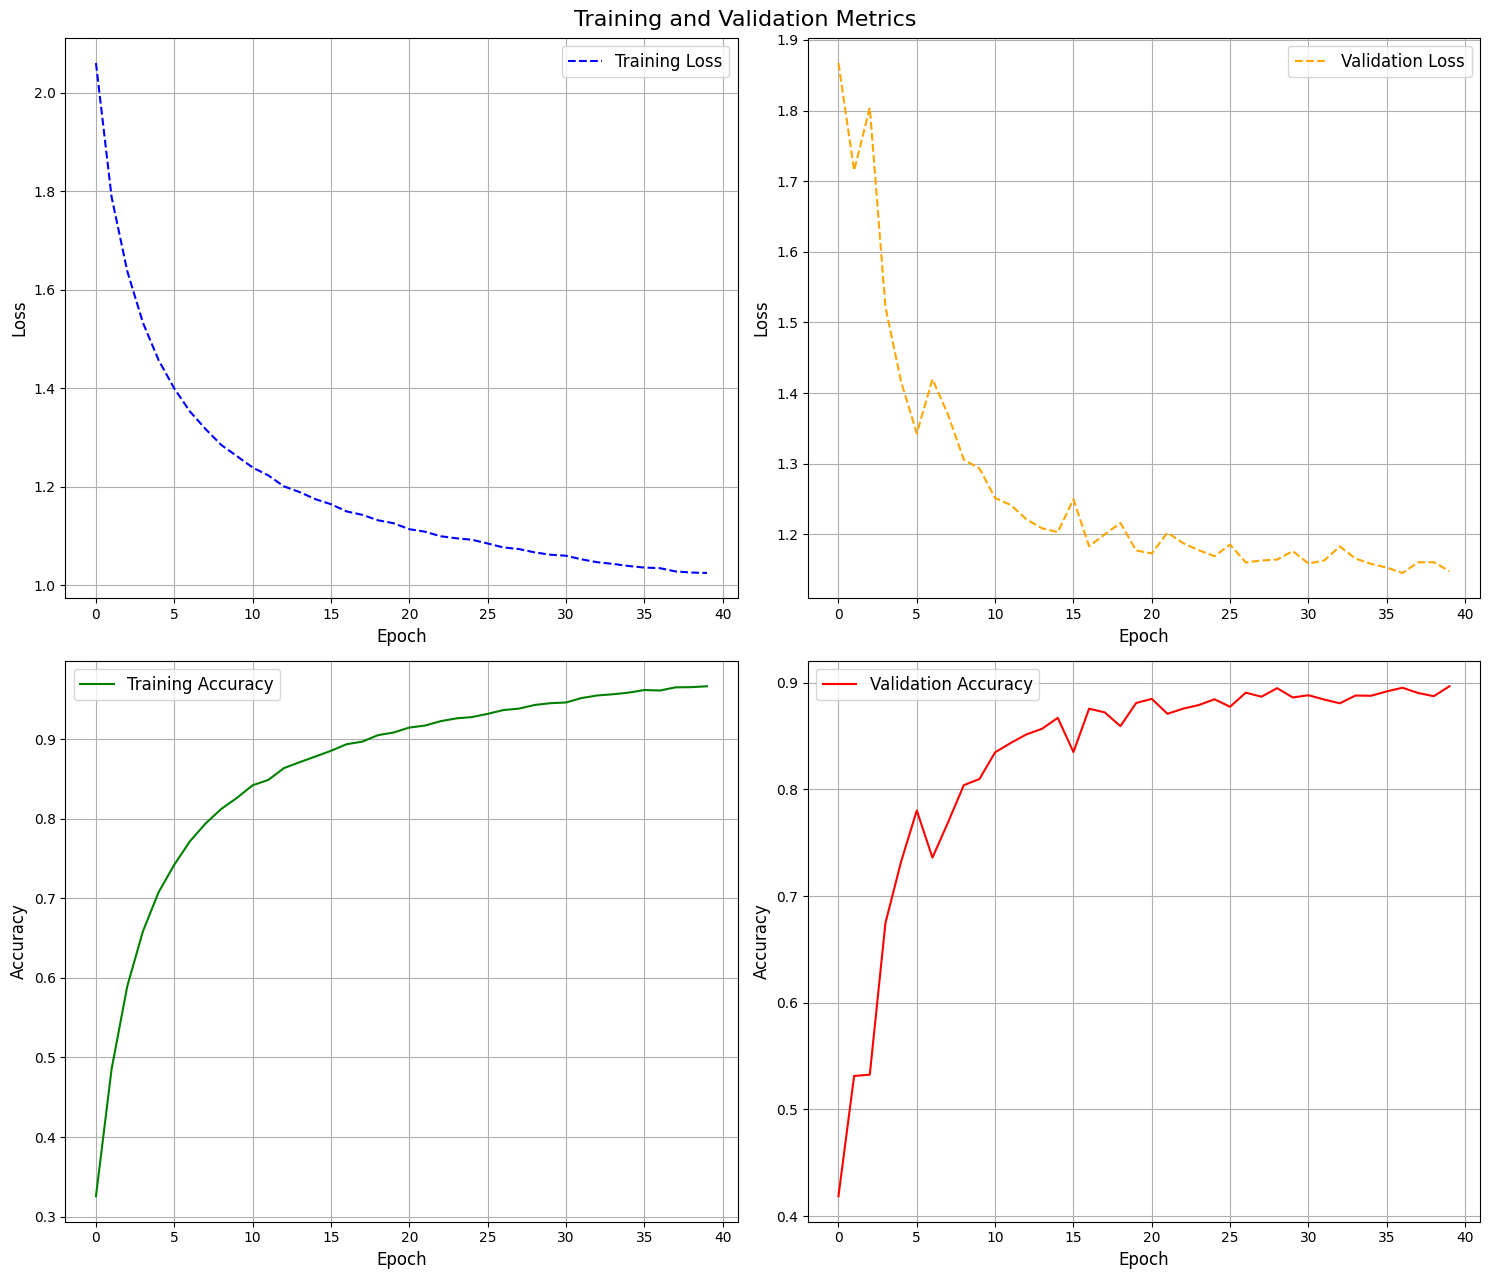

In [11]:
# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(15, 13))

# Add a main title to the plot
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Plot training loss on the first subplot
axs[0, 0].plot(train_loss_history, label='Training Loss', color='blue', linestyle='dashed')
axs[0, 0].set_xlabel('Epoch', fontsize=12)
axs[0, 0].set_ylabel('Loss', fontsize=12)
axs[0, 0].legend(fontsize=12)
axs[0, 0].grid(True)

# Plot validation loss on the second subplot
axs[0, 1].plot(val_loss_history, label='Validation Loss', color='orange', linestyle='dashed')
axs[0, 1].set_xlabel('Epoch', fontsize=12)
axs[0, 1].set_ylabel('Loss', fontsize=12)
axs[0, 1].legend(fontsize=12)
axs[0, 1].grid(True)

# Plot training accuracy on the third subplot
axs[1, 0].plot(train_acc_history, label='Training Accuracy', color='green', linestyle='solid')
axs[1, 0].set_xlabel('Epoch', fontsize=12)
axs[1, 0].set_ylabel('Accuracy', fontsize=12)
axs[1, 0].legend(fontsize=12)
axs[1, 0].grid(True)

# Plot validation accuracy on the fourth subplot
axs[1, 1].plot(val_acc_history, label='Validation Accuracy', color='red', linestyle='solid')
axs[1, 1].set_xlabel('Epoch', fontsize=12)
axs[1, 1].set_ylabel('Accuracy', fontsize=12)
axs[1, 1].legend(fontsize=12)
axs[1, 1].grid(True)

# Adjust the layout and spacing of subplots
plt.tight_layout()

# Show the plot
plt.show()

# Task 5 - Final model accuracy on the CIFAR10 Validation Set

The model achieved impressive results with a training accuracy of 96.66% and a validation accuracy of 89.66% for the final epoch. The achieved high accuracy levels indicate that the model is successfully learning and recognizing the underlying patterns present in the data and is able to apply this knowledge to new, previously unseen data. The training loss and validation loss values of 1.0249 and 1.1479 respectively provide evidence of the model's strong performance. Additionally, the small difference between the training and validation metrics suggests that the model is not overfitting, which means it can generalize well to new data. Overall, the model has achieved a good balance between fitting the data and being able to generalize.

These high scores the result of various techniques and steps used to enhance the model's performance. Data augmentation techniques, such as RandomResizedCrop, RandomRotation, and RandomHorizontalFlip, were applied to the training set, while the validation set underwent only normalization and tensor conversion. The ResNet-based CNN model was composed of a backbone and a classifier, with the backbone extracting relevant features from the input image, and the classifier producing the final classification decision. Additionally, a custom loss function and the RMSprop optimizer with a learning rate scheduler were used to optimize the model's parameters. Overall, these steps helped to achieve a well-balanced model that is able to recognize new images with a high degree of accuracy.